In [1]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import scipy.stats as st
import pandas as pd
import math
import os
import arviz as az
from statistics import mean
from IPython.display import display, Latex
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : 9,
          'font.family' : 'lmodern'
          }
plt.rcParams.update(params) 
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import warnings
warnings.filterwarnings("ignore")

/Users/sharmila/anaconda3/envs/py36_tf2/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


In [2]:
results_dir = os.path.join(os.getcwd(), 'results_metrics/')

In [3]:
def plot(kstest_stats, d_xi):
    #mpl.rcParams.update(mpl.rcParamsDefault)
    #plt.rcParams.update({'font.size': 9})
    
    width = 7.5/2
    height = width/1.6
    figure, ax = plt.subplots(figsize=(width, height)) #figsize=(8, 6)
    df = pd.DataFrame({'col':kstest_stats})
    y, x, _=plt.hist(kstest_stats, bins = 30) #, label='Histogram of relative error in ' + title
    #plt.grid(True)
    #plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel("KS test statistic of " + r'$\xi_{%.0f}$' % (d_xi+1))
    plt.ylabel("Count",rotation=0)
    ax.yaxis.set_label_coords(0.0, 1.05)
    sns.despine(trim=True)
    plt.tight_layout(pad=0.1)
    plt.savefig('hist_kstest_stats_parameter'+ str(d_xi+1) +'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

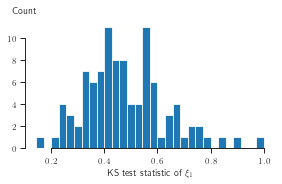

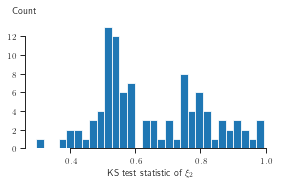

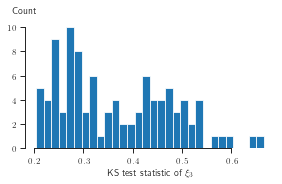

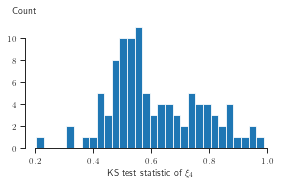

In [4]:
for d_xi in range(4):
    kstest_stats = []
    
    for j in range(100):
        xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
        xi_samples_MCMC = torch.load(results_dir +str(j)+'_MCMC'+'_xi_samples.pt')
        kstest_stat, _ = st.kstest(xi_samples_AVI[:,d_xi].detach().numpy(), xi_samples_MCMC[:,d_xi].detach().numpy())
        kstest_stats.append(kstest_stat)
    plot(kstest_stats, d_xi)    

In [5]:
lens = torch.tensor([0.5, 0.5, 1.0]) # lengths of the kinematic links

def segment_points(p_, length, angle):
    p = torch.zeros(p_.shape)
    p[:,0] = p_[:,0] + length * torch.cos(angle)
    p[:,1] = p_[:,1] + length * torch.sin(angle)
    return p_, p

def forward_process(xi): # N x d_xi
    """
    Implements the forward process f(xi) and 
    and returns each of the arm’s end points as dictionary.
    """
    values = dict();
    xi = xi.reshape(-1,4)
    A = torch.stack([torch.zeros((xi.shape[0])), xi[:, 0]], axis=1)
    _, B = segment_points(A, lens[0], xi[:,1])
    _, C = segment_points(B, lens[1], xi[:,1] + xi[:,2])
    _, D = segment_points(C, lens[2], xi[:,1] + xi[:,2] + xi[:,3])
    values['A'] = A
    values['B'] = B
    values['C'] = C
    values['D'] = D
    return values;

In [6]:
xi_data, y_data = torch.load(results_dir +'xi_data.pt'), torch.load(results_dir +'y_data.pt')
xi_data.shape, y_data.shape

(torch.Size([100, 4]), torch.Size([100, 2]))

In [7]:
metric = 0
for j in range(100):
    
    xi_samples_AVI = torch.load(results_dir +str(j)+'_AVI'+'_xi_samples.pt')
    diff = forward_process(xi_samples_AVI)['D'] - forward_process(xi_data[j].reshape(1,-1))['D']
    #print(diff.shape)
    
    metric += torch.linalg.norm(diff, 2, dim=1).mean()
    
print(metric/100)

tensor(0.0232, grad_fn=<DivBackward0>)
